In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from time import time

### Generating the Dummy Dataset And Splitting into Training and Testing datasets

We are generating a dummy dataset with 50000 observations and 15 variables of which 5 are informative and 10 are redundant. We have also defined the weights parameter as None as we want the classes in the dependent variable to be balanced. We will use this dataset to tune hyperparameters using various methods.

In [49]:
# Generating Synthetic Dataset
X, y = make_classification(n_samples=50000, 
                           n_classes=2,
                           n_features=15, 
                           n_informative=5, 
                           n_redundant=10,
                           random_state=42,
                           weights=None)

In [50]:
# Splitting the data into train, test datasets
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.2,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(40000, 15)
(40000,)
(10000, 15)
(10000,)


### Manual Hyperparameter Tuning

In [51]:
%%time
# Running the Random Forest model only varying the n_estimator parameter
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=8,
                            max_features='sqrt',
                            min_samples_leaf=25,
                            min_samples_split=30,
                            n_jobs=-1,
                            random_state=42)

# Fitting the model on training datasets
rf.fit(X_Train,y_Train)

# predicting on training and testing datasets
training_predictions = rf.predict(X_Train)
testing_predictions = rf.predict(X_Test)

# checking the accuracy score on training and testing datasets
print ("Accuracy Score on Training Dataset is: {}".format(accuracy_score(y_Train,training_predictions)))
print ("Accuracy Score on Testing Dataset is: {}".format(accuracy_score(y_Test,testing_predictions)))

Accuracy Score on Training Dataset is: 0.941575
Accuracy Score on Testing Dataset is: 0.9373
Wall time: 5.76 s


We can see that it took around 4 seconds to run the model with the default number of estimators or trees. As the number of trees increases, so does the training time and the accuracy score. 

In [52]:
%%time
n_estimators = [100,200,500,750,1000]
testing_scores  = []
training_scores = []

for value in n_estimators:
    
    # Building the model with different values of n_estimators
    rf = RandomForestClassifier(n_estimators=value,
                                max_depth=8,
                                max_features='sqrt',
                                min_samples_leaf=25,
                                min_samples_split=30,
                                n_jobs=-1,
                                random_state=42)
    
    # Fitting the model on training datasets
    rf.fit(X_Train,y_Train)

    # predicting on training and testing datasets
    training_predictions = rf.predict(X_Train)
    testing_predictions = rf.predict(X_Test)

    # checking the accuracy score on training and testing datasets
    training_accuracy_score = accuracy_score(y_Train,training_predictions)
    testing_accuracy_score  = accuracy_score(y_Test,testing_predictions)
    
    # Appending these values to our original lists
    training_scores.append(training_accuracy_score)
    testing_scores.append(testing_accuracy_score)

Wall time: 2min 8s


* We can see that for a set of 5 values of n_estimators, it took about 2 minutes roughly, so it can be time-consuming to tune hyperparameters manually. Let us now see how it affects the accuracy score.
* We can see that for one hyperparameter, it took about 2 mins. If you want to manually tune many of them, the time taken will be significantly higher and the performance will also vary. So it is not feasible to manually tune the hyperparameters. 
* We can also see in the line plot below that as the n_estimators increase, the training and testing accuracies increase, but further increase in the n_estimators decreases both accuracies. 

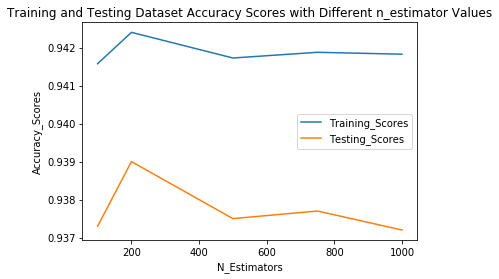

In [53]:
df = pd.DataFrame({'Training_Scores': training_scores,'Testing_Scores':  testing_scores}, index=n_estimators)

df.plot.line();
plt.xlabel("N_Estimators");
plt.ylabel('Accuracy_Scores');
plt.title("Training and Testing Dataset Accuracy Scores with Different n_estimator Values");

### Hyperparameter Tuning with Random Search

Now we shall see how to tune the Hyperparameters of the Random Forest model using the RandomizedsearchCV library from scikit-learn. 

There are a few things to note about RandomizedsearchCV implementation from scikit-learn,

1. We need to pass the parameters in the form of distribution or grid-like with key-value pairs, like in a dictionary.
2. It performs cross-validation, so that overfitting does not happen.
3. For classification problems, by default, StratifiedKFold cross-validation is performed and for Regression problems, KFold cross-validation is performed. This is helpful in case the dependent variable is imbalanced.
4. It also has methods like predict_proba in case you want to predict probabilities, best_score_ to know the best score obtained, best_params_ to get the best parameters that the model has learned, etc. 
5. You can also define the number of combinations of parameter settings, it is defined by n_iter.
6. You can also define the scoring parameter of your choice. 

In [54]:
%%time
# Defining the hyperparameter distributions
param_distributions = {"n_estimators":list(range(100,600,100)),
                       "max_depth":list(range(4,11,2)),
                       "max_features":['sqrt','log2',0.5],
                       "min_samples_leaf":list(range(5,21,5)),
                       "min_samples_split":list(range(15,40,10))}

# defining the model
model = RandomForestClassifier(n_jobs=-1,random_state=42)

# defining the search
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=5)

# fitting the random search with dependent and independent variable
random_search.fit(X,y)

Wall time: 12min 24s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [5, 10, 15, 20],
                                        'min_samples_split': [15, 25, 35],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='accuracy')

As you can see from the output above, the search took about 12.5 mins to run. We can also check the best score, best parameters etc using the functions provided by scikit learn.

In [55]:
# Checking the best score
print (random_search.best_score_)

0.9483599999999999


In [56]:
# Checking the best set of parameters
print (random_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 35, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 10}


In [57]:
# Checking the best estimator
print (random_search.best_estimator_)

RandomForestClassifier(max_depth=10, max_features=0.5, min_samples_leaf=5,
                       min_samples_split=35, n_estimators=200, n_jobs=-1,
                       random_state=42)


Although there were fewer hyperparameters to search for, it took some time to search because of the size of the dataset and 5 fold cross-validation that is performed. So it becomes important to narrow down your search criteria if your dataset is large so that the time taken is less.

### Hperparaeter Tuning With Grid Search

Now we shall see how to tune the Hyperparameters of the Random Forest model using GridsearchCV library from scikit-learn. 

There are a few things to note about GridsearchCV implementation from scikit-learn,

1. We need to pass the parameters in the form of distribution or grid-like with key-value pairs, like in a dictionary.
2. It performs cross-validation so that overfitting does not happen.
3. For classification problems, by default, StratifiedKFold cross-validation is performed and for Regression problems, KFold cross-validation is performed. This is helpful in case the dependent variable is imbalanced.
4. It also has methods like predict_proba in case you want to predict probabilities, best_score_ to know the best score obtained, best_params_ to get the best parameters that the model has learned, etc. 
5. You can also define the scoring parameter of your choice. 

Few differences between RandomizedsearchCV and GridsearchCV implementations are,
1. In RandomizedsearchCV, not all combinations of hyperparameters are searched (this is defined by n_iter), but in GridsearchCV, all possible combinations are searched.
2. GridsearchCV takes a significantly longer time than RandomizedsearchCV because of a large number of combinations.

In [61]:
%%time
# Defining the hyperparameter grid
param_grid = {"n_estimators":list(range(100,300,50)),
              "max_depth":list(range(6,11,2))}

# defining the model
model = RandomForestClassifier(n_jobs=-1,
                               max_features=.5,
                               min_samples_leaf=5,
                               min_samples_split=35,
                               random_state=42)

# defining the search
grid_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   scoring='accuracy',
                                   cv=5)

# fitting the grid search with dependent and independent variable
grid_search.fit(X,y)

Wall time: 17min 20s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_features=0.5,
                                                    min_samples_leaf=5,
                                                    min_samples_split=35,
                                                    n_jobs=-1,
                                                    random_state=42),
                   param_distributions={'max_depth': [6, 8, 10],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='accuracy')

We can note from the output above that it took more than 13 mins to run the grid search, even though the number of hyperparameters to search was less than that of Random Search. This is because, in Grid Search, every possible combination is checked. For example, in the above code, there are 12 combinations checked. 4 from n_estimators and 3 from max_depth. This combined with the large size of the dataset and 5 fold cross-validation, will take a significantly long time. 

Usually, Random Search is used in the beginning to narrow down the parameters to a few values, and then to further fine-tune, grid search is used. 

Similar to RandomizedsearchCV, in Grid search as well, we can see the best score, best estimator, best parameters, etc.

In [62]:
# checking the best score
print (grid_search.best_score_)

0.9483599999999999


In [64]:
# checking the best parameters
print (grid_search.best_params_)

{'n_estimators': 200, 'max_depth': 10}


In [65]:
# checking the best estimator
print (grid_search.best_estimator_)

RandomForestClassifier(max_depth=10, max_features=0.5, min_samples_leaf=5,
                       min_samples_split=35, n_estimators=200, n_jobs=-1,
                       random_state=42)
